In [1]:
import datetime
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import scipy
import seaborn as sns
import talib
import time

from statsmodels.tsa.stattools import coint
from tqdm.notebook import tqdm
from urllib.parse import urlencode

plt.rcParams["figure.figsize"] = (20, 10)

In [24]:

def fetch_ohlc(sym, binsize='1m', **kwargs):
    # https://docs.bitmex.com/api-explorer/get-trade-bucketed    
    query = {'symbol': sym, 'binSize': binsize, 'count': 1000, 'reverse': 'true'} | kwargs
    r = requests.get(f'https://www.bitmex.com/api/v1/trade/bucketed?{urlencode(query)}')
    if int(r.headers['x-ratelimit-remaining']) < 10:
        wait = int(r.headers['x-ratelimit-reset']) - time.time()
        time.sleep(wait + 5)
    return r.json()


def data_ohlc(sym, binsize='1m', count=5000):
    rows = fetch_ohlc(sym, binsize=binsize, endTime=datetime.date.today().isoformat())
    lookup = {'1m': 'minutes', '1h': 'hours', '1d': 'days'}
    key = lookup[binsize]
    
    while len(rows) < count:
        end_time = dateutil.parser.isoparse(rows[-1]['timestamp'])
        end_time -= datetime.timedelta(**{key: 1})
        end_iso = end_time.replace(tzinfo=None).isoformat() + 'Z'
        data = fetch_ohlc(sym, binsize=binsize, endTime=end_iso)
        if len(data) == 0:
            break
        rows.extend(data)
        
    cf = pd.DataFrame(rows).sort_values('timestamp')
    return cf.drop_duplicates().reset_index(drop=True)


In [26]:
syms = ['XBTUSD', 'XBTH26']
times = set()
frames = []

for sym in tqdm(syms):
    cf = data_ohlc(sym, binsize='1h')
    xf = cf[['timestamp', 'close']]
    xf.columns = ['time', sym]
    times |= set(xf['time'])
    frames.append(xf)
    
dh = pd.DataFrame(sorted(times), columns=['time'])

for xf in frames:
    dh = dh.merge(xf, on='time', how='left')
    
dh

  0%|          | 0/2 [00:00<?, ?it/s]

,time,XBTUSD,XBTH26
0,2025-04-22T17:00:00.000Z,90673.5,NaN
1,2025-04-22T18:00:00.000Z,91401.9,NaN
2,2025-04-22T19:00:00.000Z,91476.1,NaN
3,2025-04-22T20:00:00.000Z,91390.9,NaN
4,2025-04-22T21:00:00.000Z,91098.1,NaN
...,...,...,...
4995,2025-11-16T20:00:00.000Z,93918.0,95283.5
4996,2025-11-16T21:00:00.000Z,94000.2,95557.0
4997,2025-11-16T22:00:00.000Z,93417.6,94742.0
4998,2025-11-16T23:00:00.000Z,94048.6,95799.5


In [30]:
dh = dh.dropna().reset_index(drop=True)

dh['spread'] = dh['XBTH26'] - dh['XBTUSD']
dh

,time,XBTUSD,XBTH26,spread
0,2025-07-02T05:00:00.000Z,106359.6,106650.0,290.4
1,2025-07-02T06:00:00.000Z,106608.1,106650.0,41.9
2,2025-07-02T07:00:00.000Z,106990.2,106650.0,-340.2
3,2025-07-02T08:00:00.000Z,107075.9,112395.0,5319.1
4,2025-07-02T09:00:00.000Z,107722.8,112650.0,4927.2
...,...,...,...,...
3303,2025-11-16T20:00:00.000Z,93918.0,95283.5,1365.5
3304,2025-11-16T21:00:00.000Z,94000.2,95557.0,1556.8
3305,2025-11-16T22:00:00.000Z,93417.6,94742.0,1324.4
3306,2025-11-16T23:00:00.000Z,94048.6,95799.5,1750.9


<Axes: xlabel='time'>

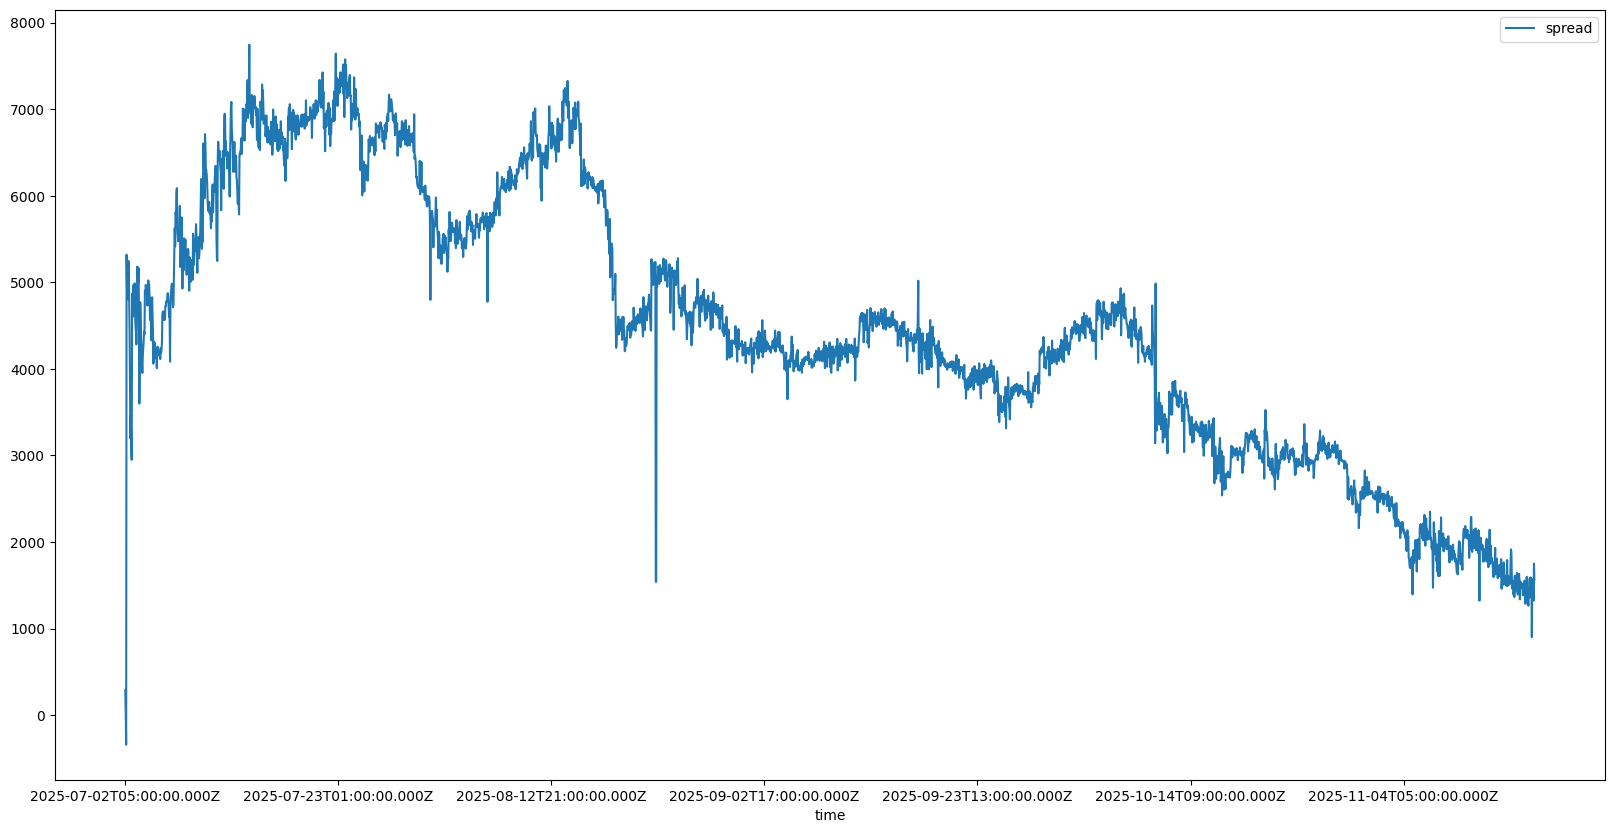

In [31]:
dh.plot(x='time', y='spread')

In [3]:
C = fetch_ohlc('ETHUSD')
C[0]

{'timestamp': '2025-11-17T17:32:00.000Z',
 'symbol': 'ETHUSD',
 'open': 3098.23,
 'high': 3096.45,
 'low': 3092.95,
 'close': 3092.95,
 'trades': 14,
 'volume': 39,
 'vwap': 3094.74,
 'lastSize': 1,
 'turnover': 12069453,
 'homeNotional': 3.6438126652530167,
 'foreignNotional': 11276.623438658951}

In [4]:
syms = ['XBTUSD', 'XBTH26']
times = set()
frames = []

for sym in tqdm(syms):
    cf = data_ohlc(sym)
    xf = cf[['timestamp', 'close']]
    xf.columns = ['time', sym]
    times |= set(xf['time'])
    frames.append(xf)
    
df = pd.DataFrame(sorted(times), columns=['time'])

for xf in frames:
    df = df.merge(xf, on='time', how='left')
    
df

  0%|          | 0/2 [00:00<?, ?it/s]

,time,XBTUSD,XBTH26
0,2025-11-13T12:41:00.000Z,103000.1,104657.5
1,2025-11-13T12:42:00.000Z,103094.9,104657.5
2,2025-11-13T12:43:00.000Z,103091.9,104657.5
3,2025-11-13T12:44:00.000Z,103101.9,104657.5
4,2025-11-13T12:45:00.000Z,103115.9,104657.5
...,...,...,...
4995,2025-11-16T23:56:00.000Z,94205.0,95735.0
4996,2025-11-16T23:57:00.000Z,94248.7,95735.5
4997,2025-11-16T23:58:00.000Z,94184.0,95735.0
4998,2025-11-16T23:59:00.000Z,94140.0,95735.0


In [9]:
P = df['XBTUSD'] # P
F = df['XBTH26'] # F

tstat, pvalue, _ = coint(P, F, trend='ct')

# if pvalue < 0.05 then (y0, y1) is cointegrated
pvalue

3.8916634022406005e-11

```
P ~ const + beta * F
```

In [10]:
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

Fc = sm.add_constant(F)

model = sm.OLS(P, Fc)
results = model.fit()

In [11]:
const = results.params[0]
beta = results.params[1]

const, beta

(2316.4625290264753, 0.9607854379259243)

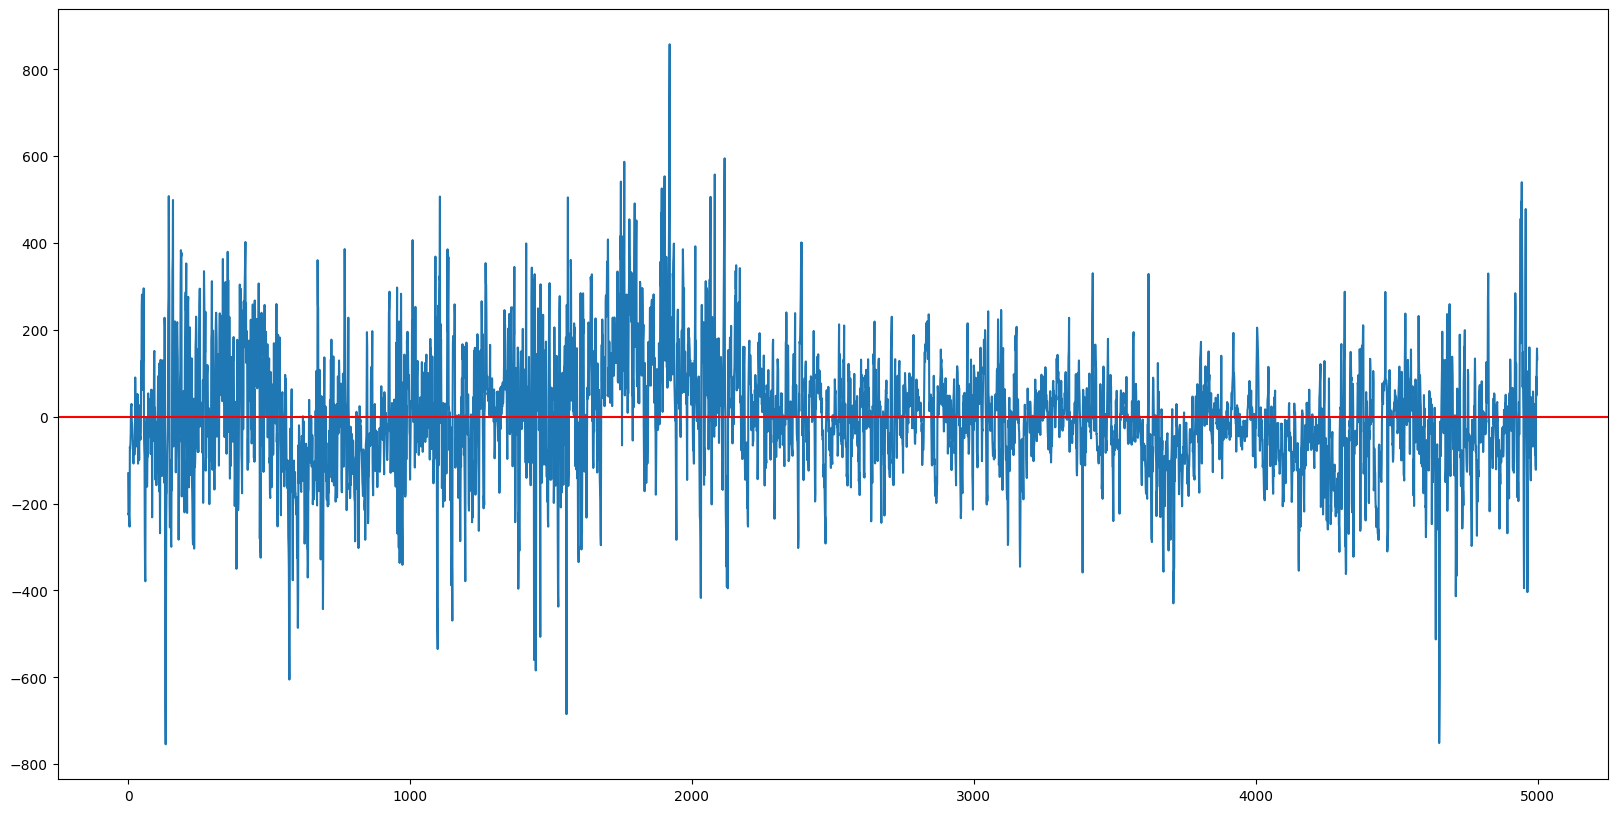

In [12]:
Z = (const + beta * F - P)

Z.plot()

plt.axhline(0, color='r')

In [16]:
mean, std = np.mean(Z), np.std(Z)
mean, std

(-1.4149787602946162e-09, 138.20792541675598)

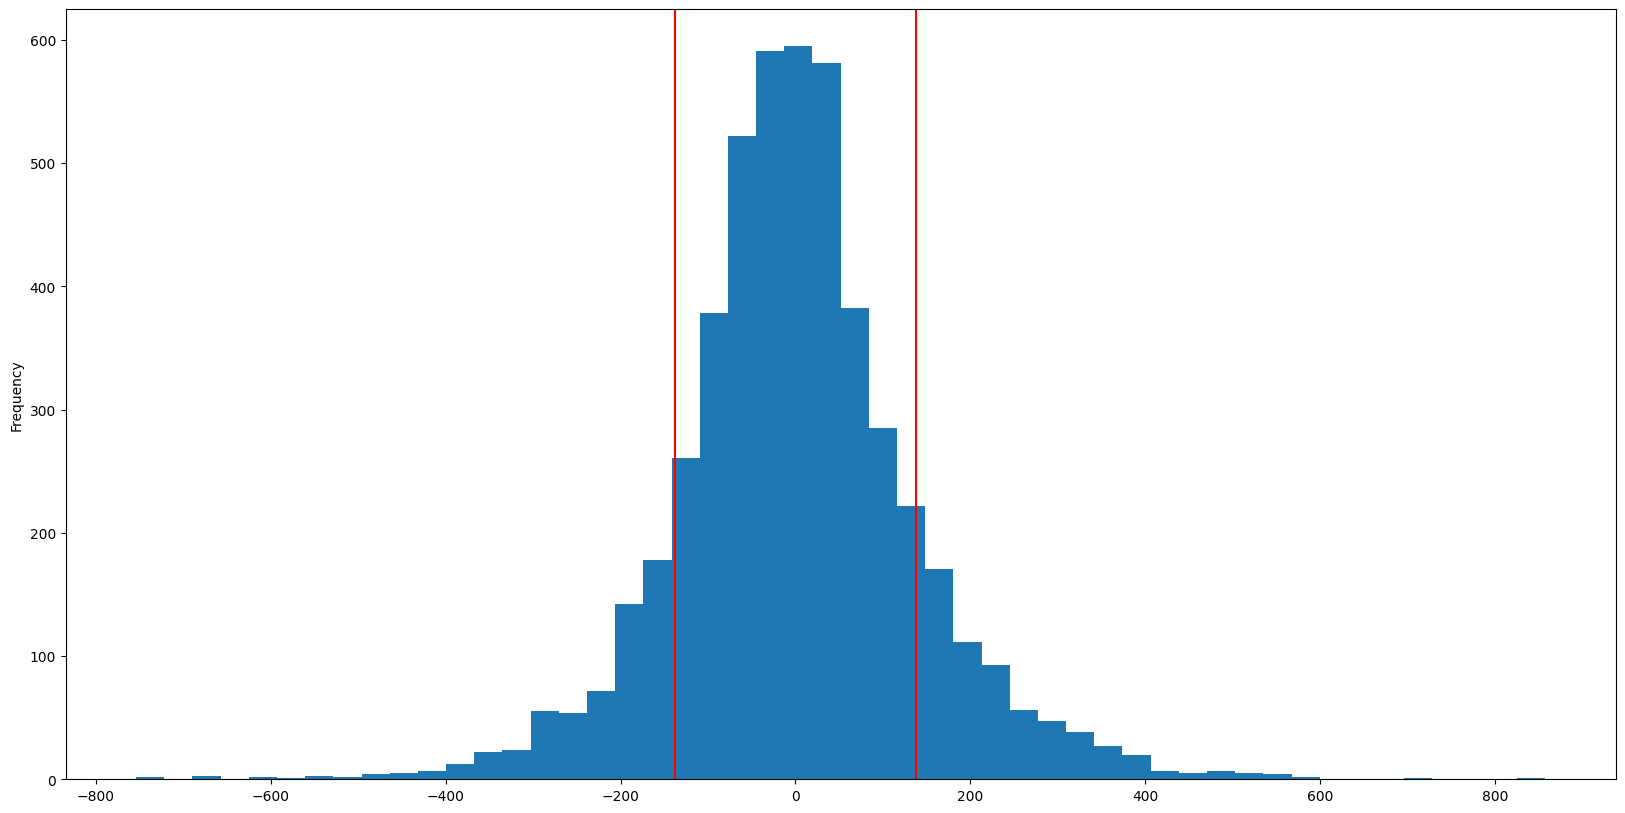

In [19]:
Z.plot(kind='hist', bins=50)

plt.axvline(std, color='r')
plt.axvline(-std, color='r')

In [32]:
Z[-20:]

4980    -15.502479
4981     14.297521
4982    -30.902479
4983    -68.602479
4984     58.060356
4985     28.260356
4986     -3.039644
4987     18.460356
4988      2.060356
4989     28.860356
4990    -29.439644
4991    -87.839644
4992    -60.039644
4993   -110.939644
4994   -122.039644
4995     92.256429
4996     49.036822
4997    113.256429
4998    157.256429
4999    132.356429
dtype: float64